In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD

In [91]:
tf.random.set_seed(1234)

In [92]:
data_path = 'AAPL.csv'

In [93]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 08D4-494E

 Directory of c:\Users\hamat\Documents\Projects\B_S_Trade\data-api\assets\model

05/16/2024  06:03 PM    <DIR>          .
05/16/2024  03:45 PM    <DIR>          ..
05/16/2024  05:17 PM           261,307 AAPL.csv
05/16/2024  06:06 PM           223,416 APPLE_GRU_trial.ipynb
05/16/2024  06:08 PM         4,656,488 gru.h5
               3 File(s)      5,141,211 bytes
               2 Dir(s)  43,284,582,400 bytes free


In [94]:
df=pd.read_csv(data_path)

In [95]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [96]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [97]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-07-08,4.854286,4.930000,4.800714,4.900714,4.154235,575929200.0
1,2009-07-09,4.920000,4.928214,4.854643,4.870000,4.128201,343025200.0
2,2009-07-10,4.869286,4.963214,4.868571,4.947143,4.193594,445275600.0
3,2009-07-13,4.983571,5.083571,4.911786,5.083571,4.309240,483501200.0
4,2009-07-14,5.072500,5.113571,5.041429,5.081071,4.307120,347247600.0


In [98]:
df.isnull().sum().sum()

0

In [99]:
df.duplicated().sum()

0

In [100]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Year'] = df['Date'].dt.year

In [101]:
train_size = int(len(df)*0.8)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]



In [102]:
train_data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Year                  int32
dtype: object

In [103]:
train_data['Open']

0         4.854286
1         4.920000
2         4.869286
3         4.983571
4         5.072500
           ...    
2919    136.479996
2920    135.899994
2921    134.350006
2922    135.490005
2923    131.250000
Name: Open, Length: 2924, dtype: float64

In [104]:
scaler = MinMaxScaler().fit(np.array(train_data['Open']).reshape(-1,1))
train_scaled = scaler.transform(np.array(train_data['Open']).reshape(-1,1))
test_scaled = scaler.transform(np.array(test_data['Open']).reshape(-1,1))

In [105]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)


In [106]:
X_test

array([[[0.89621295],
        [0.90370873],
        [0.88763609],
        ...,
        [0.84179689],
        [0.83069744],
        [0.84179689]],

       [[0.90370873],
        [0.88763609],
        [0.85700457],
        ...,
        [0.83069744],
        [0.84179689],
        [0.85628384]],

       [[0.88763609],
        [0.85700457],
        [0.86550934],
        ...,
        [0.84179689],
        [0.85628384],
        [0.85779739]],

       ...,

       [[1.33384808],
        [1.33283905],
        [1.34091133],
        ...,
        [1.27669321],
        [1.27741389],
        [1.2906035 ]],

       [[1.33283905],
        [1.34091133],
        [1.33327147],
        ...,
        [1.27741389],
        [1.2906035 ],
        [1.29370275]],

       [[1.34091133],
        [1.33327147],
        [1.33680315],
        ...,
        [1.2906035 ],
        [1.29370275],
        [1.30948693]]])

In [76]:

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (2894, 30, 1)
y_train.shape:  (2894, 1)
X_test.shape:  (701, 30, 1)
y_test.shape:  (701, 1)


In [77]:
def create_gru():
    model = Sequential()
    # Input layer
    model.add(GRU (units = 64, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(GRU(units = 128,return_sequences = True))
    model.add(Dropout(0.2))
    model.add(GRU(units = 256))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    learning_rate=6e-5
    #HP
    #optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    #loss = tf.keras.losses.Huber()
    #Compile model
    #model.compile(loss=loss, optimizer=optimizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate),loss="mean_squared_error")
    return model
model_gru = create_gru()

In [78]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 200,
                        validation_split = 0.1,
                        batch_size = 32, shuffle = False,
                        callbacks = [early_stop],verbose=1)
    return history, model
history_gru, model_gru = fit_model(model_gru)

Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 4.8874e-04 - val_loss: 0.0238
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.5912e-04 - val_loss: 0.0010
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 8.1164e-05 - val_loss: 0.0010
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 6.2452e-05 - val_loss: 9.8651e-04
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 6.8350e-05 - val_loss: 0.0011
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 7.5675e-05 - val_loss: 9.9888e-04
Epoch 9/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 5.9361e-05 - val_loss: 0.0011
Epoch 10/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 7.2235e-05 - val_loss: 0.0011
Epoch 11/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 5.8335e-05 - val_loss: 9.8693e-04
Epoc

In [79]:

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

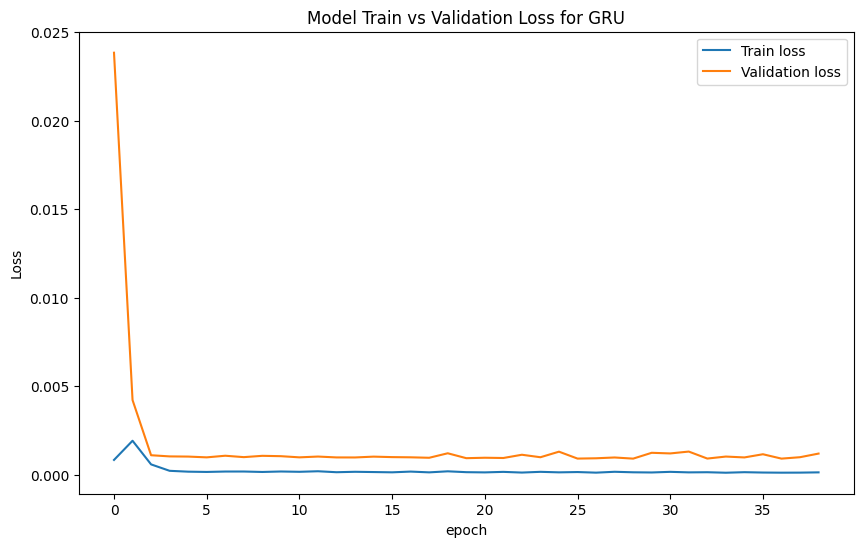

In [80]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


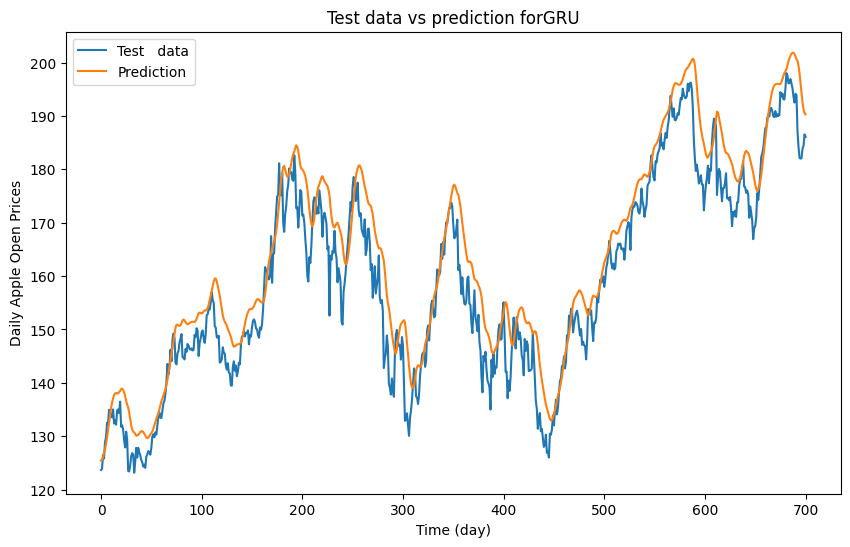

In [81]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
predictions= prediction(model_gru)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test),
             label='Test   data')
    plt.plot(np.arange(range_future),
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for'  + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily Apple Open Prices')

plot_future(predictions, 'GRU', y_test)


In [82]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions-actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(predictions, y_test, 'GRU')

GRU:
Mean Absolute Error: 5.3676
Root Mean Square Error: 6.6927



22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


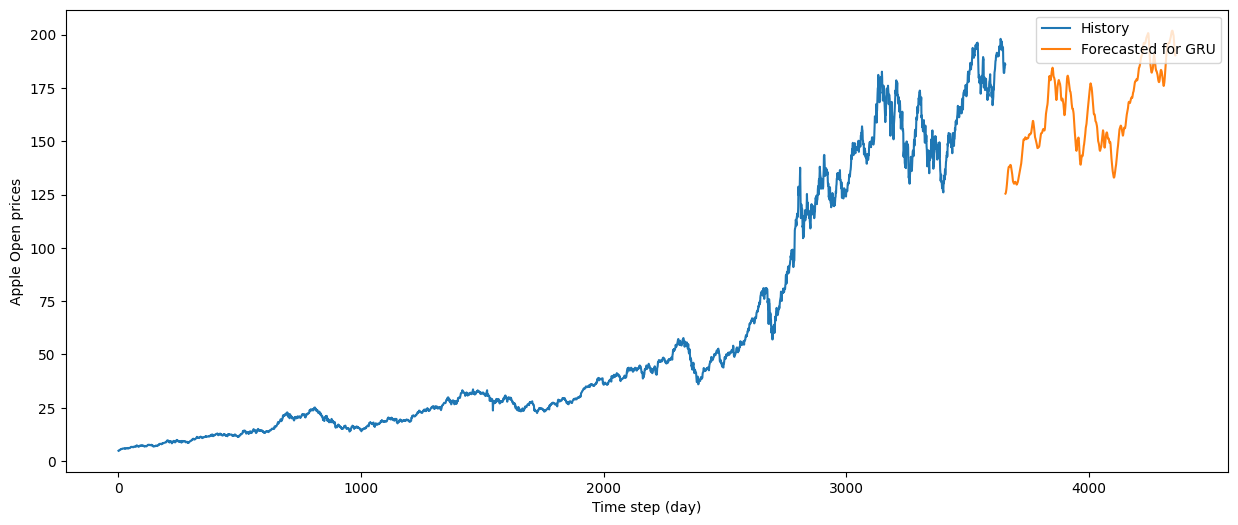

In [83]:
# Make prediction for new data
def prediction(model):
    test=30
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
# Plot history and future
def plot_two_step(history, prediction1):

    plt.figure(figsize=(15, 6))

    range_history = len(history)
    range_future = list(range(range_history, range_history +
                        len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history).reshape(-1),
             label='History')
    plt.plot(range_future, np.array(prediction1).reshape(-1),
             label='Forecasted for GRU')


    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Apple Open prices')

plot_two_step(df.Open, predictions)

In [84]:
percentage_accuracy = 100 * (1 - np.mean(np.abs(predictions - y_test) / (np.abs(y_test))))
print(f'Percentage Accuracy: {percentage_accuracy:.2f}%')

Percentage Accuracy: 96.55%


In [85]:
model_gru.save("gru.h5")

In [86]:
loaded_model = tf.keras.models.load_model("gru.h5")

In [87]:
prediction_gru = prediction(loaded_model)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


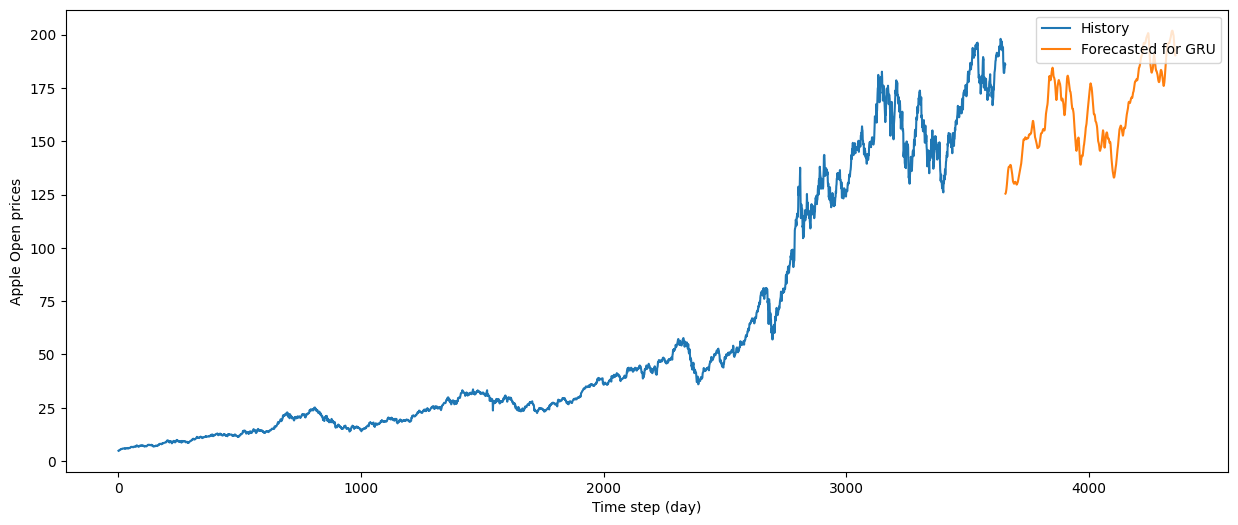

In [88]:
plot_two_step(df.Open, prediction_gru)

In [89]:
X_test

array([[[0.89621295],
        [0.90370873],
        [0.88763609],
        ...,
        [0.84179689],
        [0.83069744],
        [0.84179689]],

       [[0.90370873],
        [0.88763609],
        [0.85700457],
        ...,
        [0.83069744],
        [0.84179689],
        [0.85628384]],

       [[0.88763609],
        [0.85700457],
        [0.86550934],
        ...,
        [0.84179689],
        [0.85628384],
        [0.85779739]],

       ...,

       [[1.33384808],
        [1.33283905],
        [1.34091133],
        ...,
        [1.27669321],
        [1.27741389],
        [1.2906035 ]],

       [[1.33283905],
        [1.34091133],
        [1.33327147],
        ...,
        [1.27741389],
        [1.2906035 ],
        [1.29370275]],

       [[1.34091133],
        [1.33327147],
        [1.33680315],
        ...,
        [1.2906035 ],
        [1.29370275],
        [1.30948693]]])